In [149]:
#Import Dependencies
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [150]:
# Load dataset
data = pd.read_csv('timeseries_testv2.csv')
data.head()


,Removed,Waiting_List
0,13547,17257
1,13942,17732
2,14621,18405
3,15724,19473
4,17253,21835


In [151]:
data.dtypes

Removed         int64
Waiting_List    int64
dtype: object

In [121]:
np.asarray(data)

array([[13547, 17257],
       [13942, 17732],
       [14621, 18405],
       [15724, 19473],
       [17253, 21835],
       [18285, 22378],
       [18913, 22497],
       [20133, 23644],
       [20597, 24617],
       [21942, 27274],
       [24184, 29132],
       [25389, 31209],
       [25875, 32371],
       [26745, 32579],
       [27104, 33646],
       [27803, 34400],
       [28705, 33560],
       [28865, 34831],
       [29921, 36393],
       [31401, 36154],
       [33963, 35033],
       [35252, 35417],
       [35795, 35593],
       [36588, 38799],
       [38142, 41105],
       [33327, 33043]], dtype=int64)

In [152]:
# Fit model
model = VAR(data)
model_fit = model.fit()


In [153]:
# Make a small forecast
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)

[[33554.05900626 33578.92109699]]


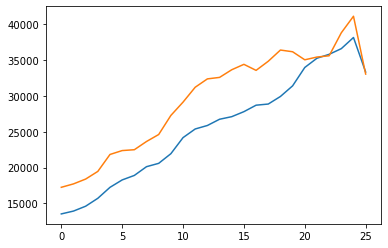

In [154]:
# Visualize, Plot This plots total Kidney removals and total Waitlist in the U.S.  The drop occurs in 2020.
plt.plot(data)

In [155]:
# Import Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(data, maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1055  , p=0.7484  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=0.1199  , p=0.7291  , df=1
likelihood ratio test: chi2=0.1196  , p=0.7294  , df=1
parameter F test:         F=0.1055  , p=0.7484  , df_denom=22, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2840  , p=0.7559  , df_denom=19, df_num=2
ssr based chi2 test:   chi2=0.7175  , p=0.6985  , df=2
likelihood ratio test: chi2=0.7070  , p=0.7022  , df=2
parameter F test:         F=0.2840  , p=0.7559  , df_denom=19, df_num=2


{1: ({'ssr_ftest': (0.10552315827753056, 0.7483684887233613, 22.0, 1),
   'ssr_chi2test': (0.11991267986083019, 0.7291292145578927, 1),
   'lrtest': (0.11962601513914706, 0.7294404606984662, 1),
   'params_ftest': (0.10552315827752877, 0.748368488723367, 22.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.28402419439118526, 0.7558886591038126, 19.0, 2),
   'ssr_chi2test': (0.7175348068829944, 0.6985368097151403, 2),
   'lrtest': (0.7070177430733793, 0.7022197627920432, 2),
   'params_ftest': (0.2840241943911567, 0.7558886591038341, 19.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [156]:
# Time to Split the data Determine validity of nobs
nobs = 4
data_train, data_test = data[0:-nobs], data[-nobs:]

In [126]:
# Check for stationarity ADF (ADF Test) / unit root test
from statsmodels.tsa.stattools import adfuller

def adf_test(ts, signif=0.05):
    datatest = adfuller(ts, autolag='AIC')
    adf = pd.Series(datatest[0:4], index=['Test Statistic', 'p-value','# Lags','# Observations'])
    for key, value in datatest[4].items():
        adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']

    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

# apply adf test on the series
adf_test(data_train["Removed"])
adf_test(data_train["Waiting_List"])

Test Statistic          -2.635286
p-value                  0.085921
# Lags                   9.000000
# Observations          12.000000
Critical Value (1%)     -4.137829
Critical Value (5%)     -3.154972
Critical Value (10%)    -2.714477
dtype: float64
 Series is Non-Stationary
Test Statistic          -4.247470
p-value                  0.000547
# Lags                   8.000000
# Observations          13.000000
Critical Value (1%)     -4.068854
Critical Value (5%)     -3.127149
Critical Value (10%)    -2.701730
dtype: float64
 Series is Stationary


In [157]:
#Make data stationary 1st difference
data_differenced = data_train.diff().dropna()
# stationary test again with differenced data
adf_test(data_differenced["Removed"])

Test Statistic          -3.256404
p-value                  0.016943
# Lags                   0.000000
# Observations          20.000000
Critical Value (1%)     -3.809209
Critical Value (5%)     -3.021645
Critical Value (10%)    -2.650713
dtype: float64
 Series is Stationary


In [99]:
# Modeling & Fitting, also determin maxlags: 9 appears to be best
model = VAR(data_differenced)
results = model.fit(maxlags=9, ic='aic')
results.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 13, Jan, 2021
Time:                     23:32:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    26.8069
Nobs:                     15.0000    HQIC:                   25.5666
Log likelihood:          -208.415    FPE:                7.86671e+11
AIC:                      25.5796    Det(Omega_mle):     2.25766e+11
--------------------------------------------------------------------
Results for equation Removed
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                1930.336376      1040.062471            1.856           0.063
L1.Removed             -0.651583         0.453344           -1.437           0.151
L1.Waiting_List        -0.297016         0.197162 

In [158]:
# Forecasting
lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)

array([[ -12280.55684988,  186021.90581774],
       [ -31742.95107218,  304986.79647371],
       [ 100164.0046138 ,  -82007.86664341],
       [ 121872.91810927, -757083.66443801],
       [-347245.75927653, -423587.03836189]])

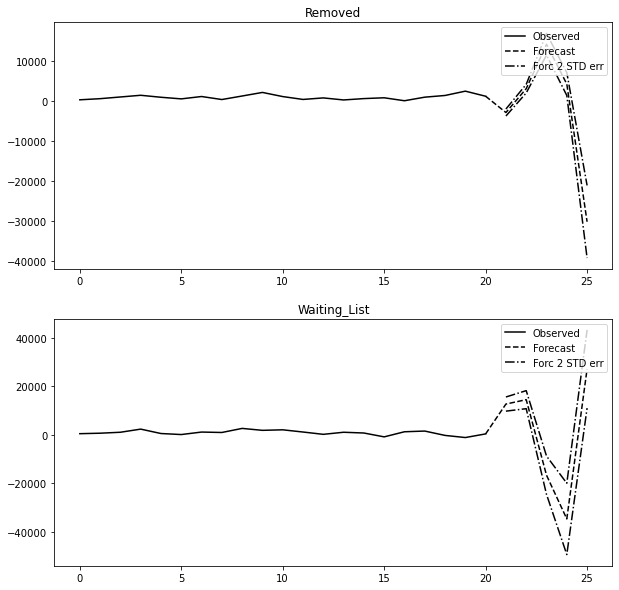

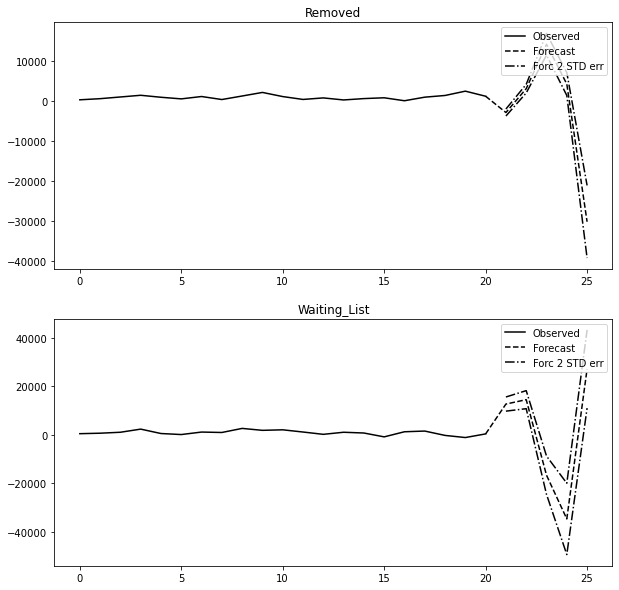

In [101]:
# Plot with Forecasts
results.plot_forecast(5)

In [159]:
# Evaluating Forecast Error Variance Decomposition (FEVD)
fevd = results.fevd(5)
fevd.summary()

FEVD for Removed
      Removed  Waiting_List
0    1.000000      0.000000
1    0.668267      0.331733
2    0.628909      0.371091
3    0.567532      0.432468
4    0.622384      0.377616

FEVD for Waiting_List
      Removed  Waiting_List
0    0.493203      0.506797
1    0.461294      0.538706
2    0.713009      0.286991
3    0.556513      0.443487
4    0.616783      0.383217


